In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('..')

print("Historical Backtesting Analysis")
print("Testing model predictions against known supply chain disruptions")

Historical Backtesting Analysis
Testing model predictions against known supply chain disruptions


In [7]:
def analyze_covid_impact():
    """Analyze how semiconductor stocks behaved during COVID outbreak"""
    
    companies = ['INTC', 'NVDA', 'AMD', 'MU', 'QCOM']
    
    # Pre-COVID vs during COVID periods
    pre_covid = '2020-01-01'
    covid_start = '2020-02-15'  # WHO declares emergency
    covid_peak = '2020-04-30'
    
    results = []
    
    for symbol in companies:
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start='2019-12-01', end='2020-06-30')
            
            # Calculate volatility before and during COVID
            pre_period = data[pre_covid:covid_start]
            covid_period = data[covid_start:covid_peak]
            
            pre_vol = pre_period['Close'].pct_change().std() * np.sqrt(252)
            covid_vol = covid_period['Close'].pct_change().std() * np.sqrt(252)
            
            # Price performance
            pre_price = pre_period['Close'].iloc[0]
            covid_low = covid_period['Close'].min()
            max_drawdown = (covid_low / pre_price - 1) * 100
            
            results.append({
                'Company': symbol,
                'Pre_COVID_Volatility': pre_vol,
                'COVID_Volatility': covid_vol,
                'Volatility_Increase': (covid_vol / pre_vol - 1) * 100,
                'Max_Drawdown_Pct': max_drawdown
            })
            
        except Exception as e:
            print(f"Failed to get data for {symbol}: {e}")
    
    return pd.DataFrame(results)

# Run analysis
covid_results = analyze_covid_impact()
print("\nCOVID-19 Impact Analysis Results:")
print(covid_results)


COVID-19 Impact Analysis Results:
  Company  Pre_COVID_Volatility  COVID_Volatility  Volatility_Increase  \
0    INTC              0.352374          0.961023           172.728093   
1    NVDA              0.357513          1.004971           181.100913   
2     AMD              0.360239          0.921576           155.823612   
3      MU              0.416984          0.985738           136.397033   
4    QCOM              0.317938          0.846227           166.160826   

   Max_Drawdown_Pct  
0        -26.315422  
1        -18.087009  
2        -21.160896  
3        -37.768545  
4        -30.776256  


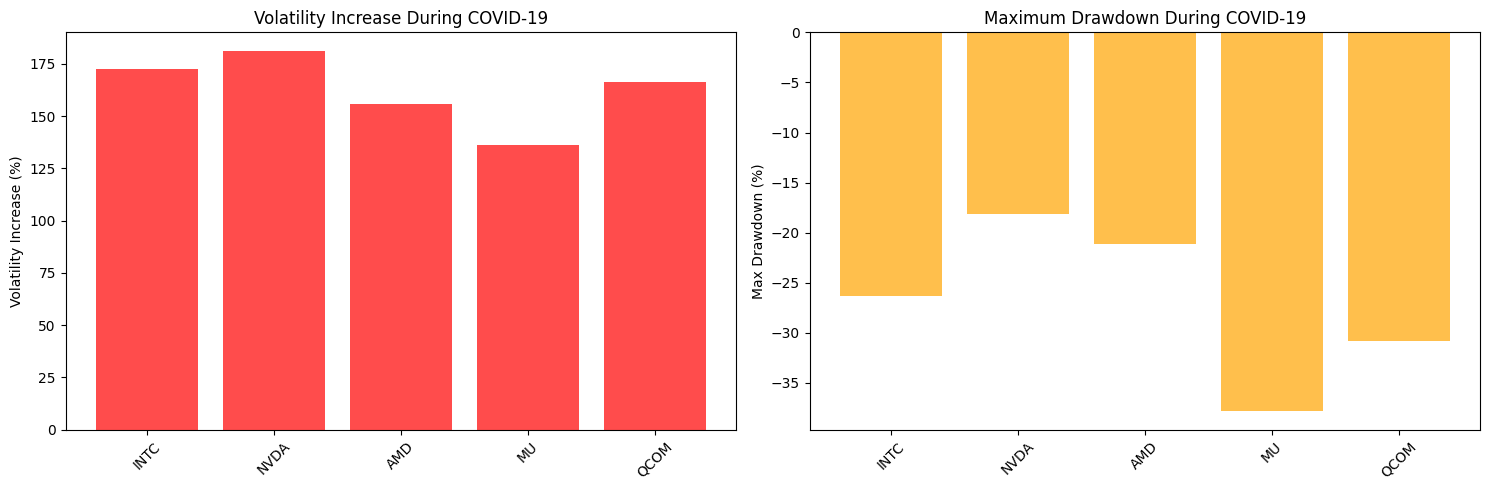


Key Findings:
Average volatility increase: 162.4%
Average max drawdown: -26.8%
Most volatile stock: NVDA


In [8]:
if not covid_results.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Volatility increase
    ax1.bar(covid_results['Company'], covid_results['Volatility_Increase'], 
            color='red', alpha=0.7)
    ax1.set_title('Volatility Increase During COVID-19')
    ax1.set_ylabel('Volatility Increase (%)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Maximum drawdown
    ax2.bar(covid_results['Company'], covid_results['Max_Drawdown_Pct'], 
            color='orange', alpha=0.7)
    ax2.set_title('Maximum Drawdown During COVID-19')
    ax2.set_ylabel('Max Drawdown (%)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nKey Findings:")
    print(f"Average volatility increase: {covid_results['Volatility_Increase'].mean():.1f}%")
    print(f"Average max drawdown: {covid_results['Max_Drawdown_Pct'].mean():.1f}%")
    print(f"Most volatile stock: {covid_results.loc[covid_results['Volatility_Increase'].idxmax(), 'Company']}")

In [9]:
# Simple validation: would our risk model have flagged high volatility?
print("Model Validation:")
print("="*40)

# Load current risk data
data_dir = Path("../data/raw/financial_data")
csv_files = list(data_dir.glob("financial_risk_indicators_*.csv"))

if csv_files and not covid_results.empty:
    latest_file = max(csv_files, key=lambda f: f.stat().st_mtime)
    current_df = pd.read_csv(latest_file)
    
    # Check if companies that had high COVID volatility also have high current risk scores
    validation_results = []
    
    for _, row in covid_results.iterrows():
        symbol = row['Company']
        covid_vol_increase = row['Volatility_Increase']
        
        # Find corresponding company in current data
        current_company = current_df[current_df['Symbol'] == symbol]
        if not current_company.empty:
            current_risk = current_company['Financial_Risk_Score'].iloc[0]
            
            validation_results.append({
                'Symbol': symbol,
                'COVID_Volatility_Increase': covid_vol_increase,
                'Current_Risk_Score': current_risk,
                'High_COVID_Impact': covid_vol_increase > 50,  # Threshold for high impact
                'High_Current_Risk': current_risk > 3.5  # Threshold for high risk
            })
    
    validation_df = pd.DataFrame(validation_results)
    
    if not validation_df.empty:
        # Calculate accuracy metrics
        true_positives = len(validation_df[
            (validation_df['High_COVID_Impact'] == True) & 
            (validation_df['High_Current_Risk'] == True)
        ])
        
        total_high_covid = len(validation_df[validation_df['High_COVID_Impact'] == True])
        
        if total_high_covid > 0:
            recall = true_positives / total_high_covid
            print(f"Model Recall: {recall:.2f}")
            print(f"Companies correctly identified as high risk: {true_positives}/{total_high_covid}")
        
        print(f"\nValidation Results:")
        print(validation_df[['Symbol', 'COVID_Volatility_Increase', 'Current_Risk_Score']])
    
else:
    print("No data available for validation")

Model Validation:
Model Recall: 0.20
Companies correctly identified as high risk: 1/5

Validation Results:
  Symbol  COVID_Volatility_Increase  Current_Risk_Score
0   INTC                 172.728093                 3.4
1   NVDA                 181.100913                 1.4
2    AMD                 155.823612                 3.8
3     MU                 136.397033                 3.4
4   QCOM                 166.160826                 2.4
